In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import seaborn as sns
import numpy as np
# import io # io is no longer needed as we read from files
from matplotlib.ticker import ScalarFormatter
import matplotlib.dates as mdates # 导入 mdates 模块

# 设置 seaborn 的风格
sns.set_theme(style="whitegrid")

matplotlib.rcParams['font.family'] = 'serif' # 设置字体家族为衬线字体
matplotlib.rcParams['font.serif'] = ['Times New Roman'] + matplotlib.rcParams['font.serif'] # 优先使用 Times New Roman
matplotlib.rcParams['mathtext.fontset'] = 'stix'



gpu_perf_file_path = 'compu2.csv'
pcie_file_path = 'PCIE.csv'
nvlink_file_path = 'NVLink.csv'
model_file_path = 'model.csv'

In [108]:
processed_dataframes = []
# --- 1. 读取并处理 GPU 性能数据 ---
try:
    # gpu_col = 'Peak FP32 (TFLOPS)'
    gpu_col = 'Peak FP16 (TFLOPS)' # Using FP16 as in the original script snippet

    # 从文件读取
    df_gpu = pd.read_csv(gpu_perf_file_path)
    df_gpu['Time'] = pd.to_datetime(df_gpu['Release Date'], format='%Y-%m') # Specify format for consistency
    df_gpu['Category'] = 'GPU FP16 (TFLOPS)'
    df_gpu['Label'] = df_gpu['GPU Model']

    # --- 确定哪些 GPU 点需要标注 ---
    df_gpu['Year'] = df_gpu['Time'].dt.year
    # Handle cases where a year might be missing data for the chosen gpu_col
    valid_gpu_perf = df_gpu.dropna(subset=[gpu_col])
    df_gpu['ShowLabel'] = True

    # if not valid_gpu_perf.empty:
    #     idx_max_tflops_per_year = valid_gpu_perf.loc[valid_gpu_perf.groupby('Year')[gpu_col].idxmax()].index
    #     df_gpu['ShowLabel'] = False
    #     df_gpu.loc[idx_max_tflops_per_year, 'ShowLabel'] = True
    # else:
    #     df_gpu['ShowLabel'] = False # If no valid data, show no labels
    #     print(f"Warning: No valid data found for column '{gpu_col}' in GPU file.")


    df_gpu = df_gpu.sort_values(by='Time')
    # Filter out potential zero/negative values before finding baseline and normalizing
    valid_gpu_norm = df_gpu[gpu_col] > 0
    if valid_gpu_norm.any():
        baseline_gpu = df_gpu.loc[valid_gpu_norm, gpu_col].iloc[0]
        df_gpu['Normalized Value'] = df_gpu[gpu_col] / baseline_gpu
        processed_df_gpu = df_gpu[['Time', 'Category', 'Normalized Value', 'Label', 'ShowLabel']].copy() # Use copy
        processed_dataframes.append(processed_df_gpu)
    else:
        print(f"Warning: No valid positive GPU data found for normalization in column '{gpu_col}'.")

except FileNotFoundError:
    print(f"错误：文件未找到，请检查路径：{gpu_perf_file_path}")
except KeyError as e:
    print(f"处理 GPU 数据时发生列名错误：请确保文件 '{gpu_perf_file_path}' 包含 'Release Date' 和 '{gpu_col}' 列。错误：{e}")
except Exception as e:
    print(f"处理 GPU 性能数据时发生错误：{e}")

In [109]:
# --- 2. 读取并处理 PCIe 带宽数据 ---
try:
    # 从文件读取
    df_pcie = pd.read_csv(pcie_file_path)
    df_pcie['Category'] = 'PCIe Bandwidth (GB/s)'
    df_pcie['Label'] = 'PCIe ' + df_pcie['PCIe Version'].astype(str)
    df_pcie['ShowLabel'] = True # 所有 PCIe 点都显示标签

    def parse_quarter_date(date_str):
        # Simplified parser assuming YYYYQ# or YYYY-MM format primarily
        date_str = str(date_str).strip() # Ensure it's a string and remove whitespace
        try:
            # Try YYYY-MM first
            return pd.to_datetime(date_str, format='%Y-%m')
        except ValueError:
            try:
            # Handle YYYYQ# format
                if 'Q' in date_str and len(date_str) == 6:
                     year = int(date_str[:4])
                     quarter = int(date_str[-1])
                     month = 3 * quarter - 1 # Estimate month: Q1->Feb, Q2->May, Q3->Aug, Q4->Nov
                     return pd.to_datetime(f'{year}-{month:02d}-15') # Use mid-month day, ensure 2-digit month
                # Handle YYYY format (assume mid-year if just year)
                elif date_str.isdigit() and len(date_str) == 4:
                     return pd.to_datetime(f'{int(date_str)}-07-01')
                else: # Attempt direct conversion as fallback
                     return pd.to_datetime(date_str)
            except Exception as inner_e:
                print(f"Warning: Could not parse date '{date_str}'. Error: {inner_e}. Returning NaT.")
                return pd.NaT # Return Not-a-Time if parsing fails


    df_pcie['Time'] = df_pcie['Approx. Release Time (Year/Quarter)'].apply(parse_quarter_date)
    # Drop rows where date parsing failed
    df_pcie.dropna(subset=['Time'], inplace=True)


    pcie_col = 'x16 Bi-directional Bandwidth (GB/s)'
    # Ensure the column is string before replacing, handle potential errors
    if pcie_col in df_pcie.columns:
        df_pcie[pcie_col] = df_pcie[pcie_col].astype(str).str.replace('~', '', regex=False)
        # Convert to numeric, coercing errors to NaN
        df_pcie[pcie_col] = pd.to_numeric(df_pcie[pcie_col], errors='coerce')
        # Drop rows where conversion failed
        df_pcie.dropna(subset=[pcie_col], inplace=True)
    else:
         raise KeyError(f"Column '{pcie_col}' not found in {pcie_file_path}")


    df_pcie = df_pcie.sort_values(by='Time')
    valid_pcie = df_pcie[pcie_col] > 0
    if valid_pcie.any():
        baseline_pcie = df_pcie.loc[valid_pcie, pcie_col].iloc[0]
        df_pcie['Normalized Value'] = df_pcie[pcie_col] / baseline_pcie
        processed_df_pcie = df_pcie[['Time', 'Category', 'Normalized Value', 'Label', 'ShowLabel']].copy() # Use copy
        processed_dataframes.append(processed_df_pcie)
    else:
        print("Warning: No valid positive PCIe data found for normalization.")


except FileNotFoundError:
    print(f"错误：文件未找到，请检查路径：{pcie_file_path}")
except KeyError as e:
     print(f"处理 PCIe 数据时发生列名错误：请检查文件 '{pcie_file_path}' 的列名。错误：{e}")
except Exception as e:
    print(f"处理 PCIe 带宽数据时发生错误：{e}")

In [110]:
# --- 3. 读取并处理 NVLink 带宽数据 ---
try:
    # 从文件读取
    df_nvlink = pd.read_csv(nvlink_file_path)
    df_nvlink['Category'] = 'NVLink Bandwidth (GB/s)'
    df_nvlink['Label'] = 'NVLink ' + df_nvlink['NVLink Version'].astype(str)
    df_nvlink['ShowLabel'] = True # 所有 NVLink 点都显示标签

    # Use the same improved date parser as for PCIe
    df_nvlink['Time'] = df_nvlink['Approx. Release Time (Year/Quarter)'].apply(parse_quarter_date)
    df_nvlink.dropna(subset=['Time'], inplace=True)

    nvlink_col = 'Total Bandwidth per GPU (GB/s)'
    # Ensure column exists and convert to numeric
    if nvlink_col in df_nvlink.columns:
        df_nvlink[nvlink_col] = pd.to_numeric(df_nvlink[nvlink_col], errors='coerce')
        df_nvlink.dropna(subset=[nvlink_col], inplace=True)
    else:
        raise KeyError(f"Column '{nvlink_col}' not found in {nvlink_file_path}")


    df_nvlink = df_nvlink.sort_values(by='Time')
    valid_nvlink = df_nvlink[nvlink_col] > 0
    if valid_nvlink.any():
        baseline_nvlink = df_nvlink.loc[valid_nvlink, nvlink_col].iloc[0]
        df_nvlink['Normalized Value'] = df_nvlink[nvlink_col] / baseline_nvlink
        processed_df_nvlink = df_nvlink[['Time', 'Category', 'Normalized Value', 'Label', 'ShowLabel']].copy() # Use copy
        processed_dataframes.append(processed_df_nvlink)
    else:
         print("Warning: No valid positive NVLink data found for normalization.")

except FileNotFoundError:
    print(f"错误：文件未找到，请检查路径：{nvlink_file_path}")
except KeyError as e:
     print(f"处理 NVLink 数据时发生列名错误：请检查文件 '{nvlink_file_path}' 的列名。错误：{e}")
except Exception as e:
    print(f"处理 NVLink 带宽数据时发生错误：{e}")

In [111]:
# --- 4. 读取并处理 AI 模型数据 ---
try:
    model_value_col = 'Parameters (Billions)'

    # 从文件读取
    df_model = pd.read_csv(model_file_path)
    # Ensure column names exist
    if 'Release Date' not in df_model.columns or model_value_col not in df_model.columns or 'Model Name' not in df_model.columns:
        raise KeyError(f"Columns 'Release Date', '{model_value_col}', or 'Model Name' not found in {model_file_path}")

    df_model['Time'] = pd.to_datetime(df_model['Release Date'], format='%Y-%m') # Specify format
    df_model['Category'] = 'Diffusion Model Size (B Params)' # Use B Params for shorter label
    df_model['Label'] = df_model['Model Name']
    df_model['ShowLabel'] = True # Label all model points for now

    # Ensure parameter column is numeric
    df_model[model_value_col] = pd.to_numeric(df_model[model_value_col], errors='coerce')
    df_model.dropna(subset=[model_value_col], inplace=True)


    df_model = df_model.sort_values(by='Time')
    valid_model = df_model[model_value_col] > 0
    if valid_model.any():
        baseline_model = df_model.loc[valid_model, model_value_col].iloc[0]
        df_model['Normalized Value'] = df_model[model_value_col] / baseline_model
        processed_df_model = df_model[['Time', 'Category', 'Normalized Value', 'Label', 'ShowLabel']].copy() # Use copy
        processed_dataframes.append(processed_df_model)
    else:
        print("Warning: No valid positive AI Model data found for normalization.")

except FileNotFoundError:
    print(f"错误：文件未找到，请检查路径：{model_file_path}")
except KeyError as e:
     print(f"处理 AI 模型数据时发生列名错误：{e}")
except Exception as e:
    print(f"处理 AI 模型数据时发生错误：{e}")


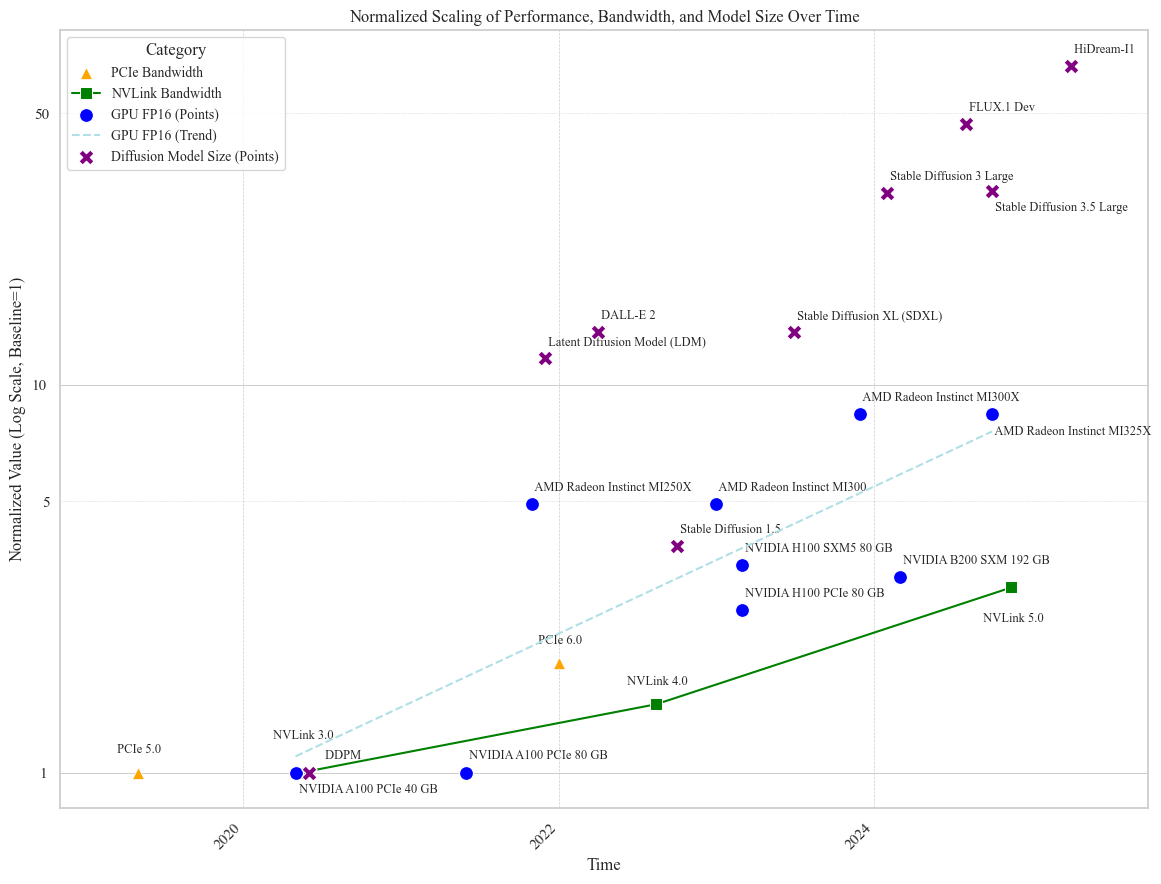

In [ ]:
# --- 5. 合并数据并绘制图表 ---

if not processed_dataframes:
    print("没有成功加载任何数据，无法绘图。请检查文件路径和内容。")
else:
    df_combined = pd.concat(processed_dataframes)
    df_combined.dropna(subset=['Time', 'Normalized Value'], inplace=True) # Drop rows missing critical values

    # Check if df_combined is empty after potential drops
    if df_combined.empty:
        print("所有数据处理后均为空或包含无效值，无法绘图。")
    else:
        plt.figure(figsize=(12, 9)) # Slightly wider figure
        ax = plt.gca()

        # --- 绘制 PCIe 和 NVLink 的折线图 ---
        df_pcie_plot = df_combined[df_combined['Category'] == 'PCIe Bandwidth (GB/s)'].copy()
        df_nvlink_plot = df_combined[df_combined['Category'] == 'NVLink Bandwidth (GB/s)'].copy()

        if not df_pcie_plot.empty:
            # sns.lineplot(data=df_pcie_plot, x='Time', y='Normalized Value', marker='^', markersize=8, linestyle='-', ax=ax, label='PCIe Bandwidth', color='orange', zorder=3)
            sns.scatterplot(data=df_pcie_plot, x='Time', y='Normalized Value', marker='^', s=80, ax=ax, label='PCIe Bandwidth', color='orange', zorder=3)
        if not df_nvlink_plot.empty:
            sns.lineplot(data=df_nvlink_plot, x='Time', y='Normalized Value', marker='s', markersize=8, linestyle='-', ax=ax, label='NVLink Bandwidth', color='green', zorder=4)
        
        # --- 绘制 GPU 性能的散点图和趋势线 ---
        df_gpu_plot = df_combined[df_combined['Category'] == 'GPU FP16 (TFLOPS)'].copy()

        if not df_gpu_plot.empty:
            sns.scatterplot(data=df_gpu_plot, x='Time', y='Normalized Value', ax=ax, label='GPU FP16 (Points)', color='blue', s=100, zorder=5)

            time_numeric = mdates.date2num(df_gpu_plot['Time'])
            # Ensure valid_indices aligns with the potentially filtered df_gpu_plot
            valid_indices = (df_gpu_plot['Normalized Value'] > 0).values # Ensure boolean array matching current df
            if valid_indices.sum() > 1:
                try:
                    # Use only valid, finite values for polyfit
                    valid_time = time_numeric[valid_indices]
                    valid_log_values = np.log10(df_gpu_plot['Normalized Value'][valid_indices])
                    finite_mask = np.isfinite(valid_time) & np.isfinite(valid_log_values)

                    if finite_mask.sum() > 1:
                        m, c = np.polyfit(valid_time[finite_mask], valid_log_values[finite_mask], 1)
                        time_for_trend = np.linspace(time_numeric.min(), time_numeric.max(), 100)
                        log_normalized_value_trend = m * time_for_trend + c
                        normalized_value_trend = 10**log_normalized_value_trend
                        dates_for_trend = mdates.num2date(time_for_trend)
                        # ax.plot(dates_for_trend, normalized_value_trend, linestyle='--', color='red', label='GPU FP16 (Trend)', zorder=5)
                        ax.plot(dates_for_trend, normalized_value_trend, linestyle='--', color='blue', label='GPU FP16 (Trend)', zorder=5)
                    else:
                        print("GPU数据中有效有限点不足(<=1)，无法绘制趋势线。")
                except Exception as fit_e:
                    print(f"GPU趋势线拟合时出错: {fit_e}")

            else:
                print("GPU数据点不足(<=1)或存在非正值，无法绘制趋势线。")


        # --- 绘制 AI 模型大小的散点图和趋势线 ---
        df_model_plot = df_combined[df_combined['Category'] == 'Diffusion Model Size (B Params)'].copy()

        if not df_model_plot.empty:
            sns.scatterplot(data=df_model_plot, x='Time', y='Normalized Value', ax=ax, label='Diffusion Model Size (Points)', color='purple', marker='X', s=120, zorder=6) # Distinct marker and size

            time_numeric_model = mdates.date2num(df_model_plot['Time'])
            valid_indices_model = (df_model_plot['Normalized Value'] > 0).values # Ensure boolean array
            
            # if valid_indices_model.sum() > 1:
            #     try:
            #          # Use only valid, finite values for polyfit
            #         valid_time_model = time_numeric_model[valid_indices_model]
            #         valid_log_values_model = np.log10(df_model_plot['Normalized Value'][valid_indices_model])
            #         finite_mask_model = np.isfinite(valid_time_model) & np.isfinite(valid_log_values_model)

            #         if finite_mask_model.sum() > 1:
            #             m_model, c_model = np.polyfit(valid_time_model[finite_mask_model], valid_log_values_model[finite_mask_model], 1)
            #             time_for_trend_model = np.linspace(time_numeric_model.min(), time_numeric_model.max(), 100)
            #             log_normalized_value_trend_model = m_model * time_for_trend_model + c_model
            #             normalized_value_trend_model = 10**log_normalized_value_trend_model
            #             dates_for_trend_model = mdates.num2date(time_for_trend_model)
            #             ax.plot(dates_for_trend_model, normalized_value_trend_model, linestyle=':', color='magenta', label='Diffusion Model Size (Trend)', zorder=6) # Distinct line
            #         else:
            #             print("AI 模型数据中有效有限点不足(<=1)，无法绘制趋势线。")
            #     except Exception as fit_e:
            #         print(f"AI 模型趋势线拟合时出错: {fit_e}")
            # else:
            #     print("AI 模型数据点不足(<=1)或存在非正值，无法绘制趋势线。")


        # --- 设置图表属性 ---

        ax.set_yscale('log')
        from matplotlib.ticker import LogLocator, ScalarFormatter
        ax.yaxis.set_major_formatter(ScalarFormatter())
        
        ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=(5.0,))) # 在5、50、0.5等位置添加次要刻度
        ax.yaxis.set_minor_formatter(ScalarFormatter())
        # Optional: Adjust y-axis limits if needed, e.g., start slightly above 0 for log scale
        # current_ylim = ax.get_ylim()
        # ax.set_ylim(bottom=max(0.1, current_ylim[0]), top=current_ylim[1])


        # --- 添加文本标注 (根据 ShowLabel 列判断) ---
        # Plot labels only if Normalized Value is valid
        df_label = df_combined.dropna(subset=['Normalized Value', 'Time'])
        for index, row in df_label.iterrows():
            if row['ShowLabel']:
                va_offset = 0
                ha_align = 'left'
                va_align = 'center' # Default vertical alignment

                if row['Category'] in ['PCIe Bandwidth (GB/s)', 'NVLink Bandwidth (GB/s)']:
                     # Add small offset based on log scale difference, avoid multiplying large numbers
                     # A small fixed offset might be better visually on log scale
                     # va_offset = row['Normalized Value'] * 0.1 # This can be too large on log
                     ha_align = 'center'
                     va_align = 'bottom' # Position label below line points
            
                x_normal_scale = 0    
                y_normal_scale = 1.1
                if row['Label'] == 'AMD Radeon Instinct MI325X':
                    y_normal_scale = 0.9
                if row['Label'] == 'NVLink 5.0':
                    y_normal_scale = 0.8
                if row['Label'] == 'NVIDIA A100 PCIe 40 GB':
                    y_normal_scale = 0.9
                if row['Label'] == 'Stable Diffusion 3.5 Large':
                    y_normal_scale = 0.9
                if row['Label'] == 'DDPM':
                    x_normal_scale = 3
                if row['Label'] == 'NVLink 3.0':
                    y_normal_scale = 1.2
                
                ax.text(
                    row['Time']+x_normal_scale*pd.Timedelta(days=10),
                    row['Normalized Value']*y_normal_scale, # Plot text right at the point's y-value
                    ' ' + str(row['Label']), # Ensure Label is string
                    fontsize=9,
                    ha=ha_align,
                    va=va_align # Use adjusted vertical alignment
                    # transform=ax.transData # Ensure using data coordinates
                )

        # Determine the overall date range from the combined data
        if not df_combined.empty:
            min_date = df_combined['Time'].min() - pd.Timedelta(days=180) # Add some padding
            max_date = df_combined['Time'].max() + pd.Timedelta(days=180)
            ax.set_xlim(min_date, max_date)


        # Format x-axis ticks for clarity
        ax.xaxis.set_major_locator(mdates.YearLocator(base=2)) # Tick every 2 years
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.YearLocator()) # Minor ticks every year


        ax.set_title('Normalized Scaling of Performance, Bandwidth, and Model Size Over Time')
        ax.set_xlabel('Time')
        ax.set_ylabel('Normalized Value (Log Scale, Baseline=1)') # Clarify Y-axis
        plt.xticks(rotation=45, ha='right')
        ax.legend(title='Category', loc='upper left', fontsize='small') # Adjust legend font size
        ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.7) # Major grid Y
        ax.grid(True, which='minor', axis='y', linestyle=':', linewidth=0.5) # Minor grid Y
        ax.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5) # Major grid X

        plt.tight_layout()
        plt.show()